# Stoxx Europe 600 Banks
The main benchmark for the European banking sector is the Stoxx Europe 600 Banks index. At the moment it comprises 39 banks, of which 22 are from the Eurozone (Germany, France, Italy, Spain, the Netherlands, Belgium, Ireland, Finland) and 17 from outside (the UK, Switzerland, Sweden, Denmark, Norway, and the Czech Republic).

In this notebook I look at:
* the market capitalization of listed domestic companies that are part of the Stoxx Europe 600 Banks index
* the total annual and daily value of stocks traded that belong to the index
* the annual and daily turover rations of stocks traded that belong to the index
* the forward annual dividend yield of banks that are part of the index
* the forward price to earnings ratio of banks that are part of the index
* the P/B and ROEs of banks that are part of the index and their cost of equity

I created my own module called `stock_market.metrics` (which is part of this repository) where I calculate capitalization, turnover, forward dividend yields and volatility of an arbitrary stock market with the help of the [yfinance](https://pypi.org/project/yfinance/) module. I use it to provide metrics on banks that are part of the [Stoxx 600 Banks Index](https://stoxx.com/index/sx7p/).

All amounts are represented in either Billions of Euros or as percentage points. Since the index has UK, Swiss, Swedish, Danish, Norwegian, and Czech Republic banks whose stocks are denominated in respective national currencies, I covert them into Euros using the exchange rate at the end of each relevant date.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader and yfinance
# !pip install pandas-datareader -U
# !pip install yfinance -U
# !pip install eurostat -U

In [2]:
import pandas as pd
from pandas.tseries.offsets import YearBegin
import numpy as np
import scipy
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from pandas_datareader import wb

from datetime import date

from stock_market import metrics, currency_converters

In [3]:
# Human readable column names for DataFrames
MKT_CAP_BANKS = 'Market capitalization of Stoxx Europe 600 Banks'
MKT_CAP_TOP10_BANKS = 'Top-10 Stoxx Europe 600 Banks by market capitalization and their share of Stoxx Europe 600 Banks'
TRAD_VOL = 'Stocks traded, total value'
TRAD_VOL_BANKS_GRAPH_TITLE = 'Stoxx Europe 600 Banks ' + TRAD_VOL + ' (annualized)'
TRAD_VOL_BANKS_GRAPH_TITLE_DAILY = 'Stoxx Europe 600 Banks ' + TRAD_VOL + ' (average daily)'
TUROVER_RATIO_BANKS = 'Turnover ratio of Stoxx Europe 600 Banks (%)'
TUROVER_RATIO_BANKS_GRAPH_TITLE = 'Stocks traded, Annual ' + TUROVER_RATIO_BANKS
TUROVER_RATIO_BANKS_DAILY_GRAPH_TITLE = 'Stocks traded, Daily ' + TUROVER_RATIO_BANKS
EXCESS_RETURN_BANKS = 'Excess Annual Return of Stoxx Europe 600 Banks over 1-year Riskless rate'

# Y axis labels for graphs
LEFT_Y_AXIS_LABEL = 'Billions of Euros'

TTM_SUFFIX = ' (ttm)'
MRQ_SUFFIX = ' (mrq)'

In [4]:
start = date(2020, 1, 1)
stoxx600_banks = metrics.EuropeBanksStockMarketMetrics.get_stoxx_europe_banks_components()
cur_conv_df = currency_converters.EuroCurrencyConverter(['.L', '.SW', '.ST', '.CO', '.OL', '.PR'], start)\
            .get_currency_conversion_df()
stoxx600_banks_metrics = metrics.EuropeBanksStockMarketMetrics(
    metrics.EuropeBanksStockMarketMetrics.tickers_to_dict(stoxx600_banks, start), None, start=start, 
    currency_conversion_df=cur_conv_df)

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  39 of 39 completed


In [5]:
# Convert into billions of Euros
banks_capitalization = stoxx600_banks_metrics.get_capitalization(frequency='MS') / 1e9
banks_annual_trading_value = stoxx600_banks_metrics.get_annual_trading_value(frequency='MS') / 1e9
banks_daily_trading_value = stoxx600_banks_metrics.get_daily_trading_value(frequency='MS') / 1e9

banks_daily_turnover = stoxx600_banks_metrics.get_daily_turnover(frequency='MS')
banks_annual_turnover = stoxx600_banks_metrics.get_annual_turnover(frequency='MS')

In [6]:
stock_mkt_banks = pd.concat([banks_capitalization, banks_annual_trading_value, banks_daily_turnover], axis=1)
stock_mkt_banks.columns = [MKT_CAP_BANKS, TRAD_VOL, TUROVER_RATIO_BANKS]
stock_mkt_banks.dropna(inplace=True)

In the below table **_Stocks traded, total value_** represents a cumulative annual amount of all transactions in   Stoxx Europe 600 Banks. **_Turnover ratio of Stoxx 600 Banks_** represents the percentage of shares outstanding that are traded per day.

In [7]:
pd.options.display.float_format = (lambda x: '{:.2%}'.format(x) if x < 5 else '€{:,.2f}bn'.format(x))
pd.options.display.max_rows = 40
stock_mkt_banks

,Market capitalization of Stoxx Europe 600 Banks,"Stocks traded, total value",Turnover ratio of Stoxx Europe 600 Banks (%)
Date,,,
2020-01-01,€930.65bn,€634.22bn,0.27%
2020-02-01,€935.34bn,€976.48bn,0.42%
2020-03-01,€634.37bn,"€1,230.85bn",0.77%
2020-04-01,€554.40bn,€725.28bn,0.52%
2020-05-01,€563.73bn,€632.61bn,0.44%
...,...,...,...
2024-04-01,"€1,176.65bn",€863.45bn,0.29%
2024-05-01,"€1,223.01bn",€848.58bn,0.28%
2024-06-01,"€1,192.56bn",€835.49bn,0.28%


## Market capitalization of Stoxx Europe 600 Banks

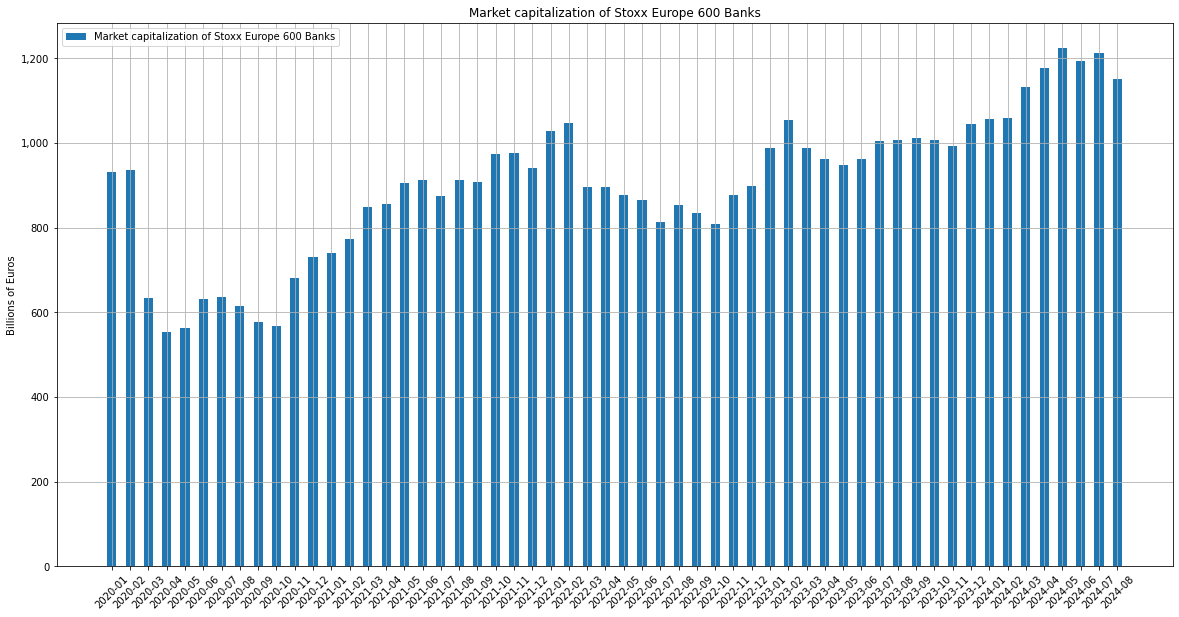

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x=range(len(stock_mkt_banks)), height=stock_mkt_banks.iloc[:,0], color='#1f77b4', width=0.5,
       label=MKT_CAP_BANKS)
ax.legend(loc='upper left')
ax.title.set_text(MKT_CAP_BANKS)
ax.grid(True)
_ = ax.set_xticks(range(len(stock_mkt_banks)), stock_mkt_banks.index)
_ = ax.set_xticklabels(stock_mkt_banks.index.strftime('%Y-%m'), rotation=45)
#ax.set_yticks(np.arange(0, 56000, 5000))
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')

### Top-10 banks  by their capitalization and their share in the overall capitalization of Stoxx Europe 600 Banks

In [9]:
top10_today = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_day(
    10, merge_additional_share_classes=True)
top10_last_month = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_month(
    10, stoxx600_banks_metrics.data.index[-1] - pd.DateOffset(months=+1))
top10_2023 = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_year(10, date(2023, 1, 1))
top10_2022 = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_year(10, date(2022, 1, 1))
top10_2021 = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_year(10, date(2021, 1, 1))
top10_2020 = stoxx600_banks_metrics.get_top_n_capitalization_companies_for_year(10, date(2020, 1, 1))

In [10]:
# Convert into Billions of Euros
top10 = pd.concat([top10_2020.Capitalization, top10_2021.Capitalization,
                   top10_2022.Capitalization, top10_2023.Capitalization, top10_today.Capitalization], axis=1) / 1e9
top10.columns = [stoxx600_banks_metrics.CAPITALIZATION + sfx
                 for sfx in [' in 2020', ' in 2021', ' in 2022', ' in 2023', ' now']]
top10_pct = pd.concat([top10_2020.iloc[:,1], top10_2021.iloc[:,1], top10_2022.iloc[:,1],
                       top10_2023.iloc[:,1], top10_today.iloc[:,1]], axis=1)

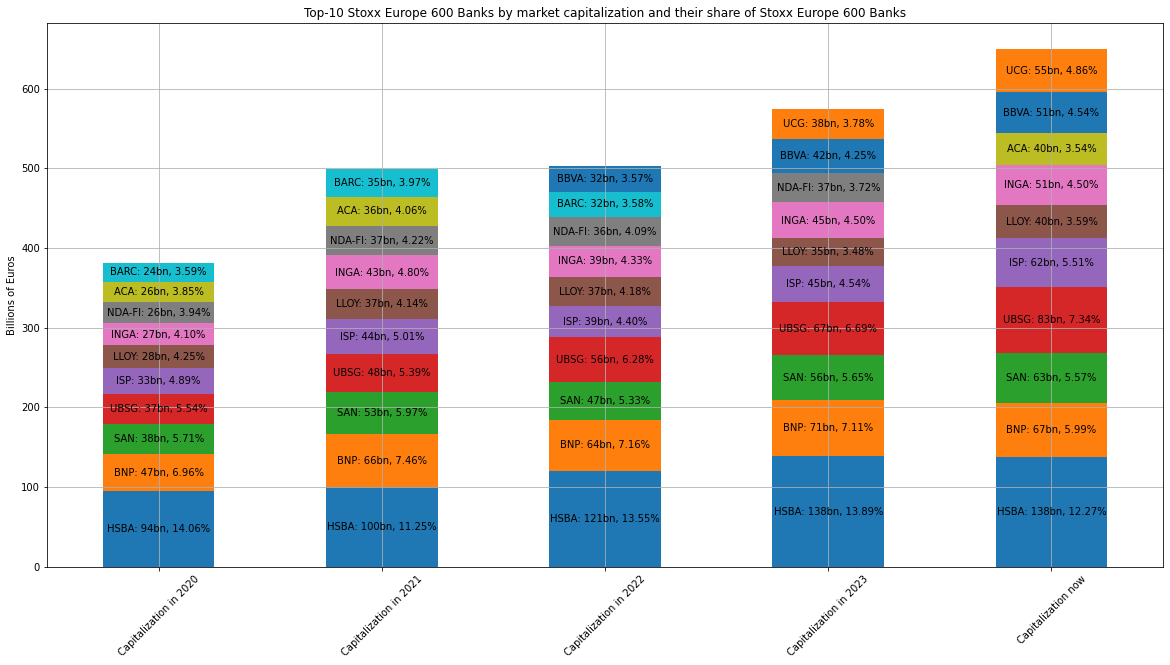

In [11]:
ax = top10.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_BANKS,
                      stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [c.get_label().split('.')[0] + f': {a:,.0f}bn, {top10_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

In [12]:
top10_now = pd.concat([top10_last_month.Capitalization, top10_today.Capitalization], axis=1) / 1e9
top10_now.columns = [stoxx600_banks_metrics.CAPITALIZATION + sfx for sfx in [' last month', ' now']]
top10_today_pct = pd.concat([top10_last_month.iloc[:,1], top10_today.iloc[:,1]], axis=1)

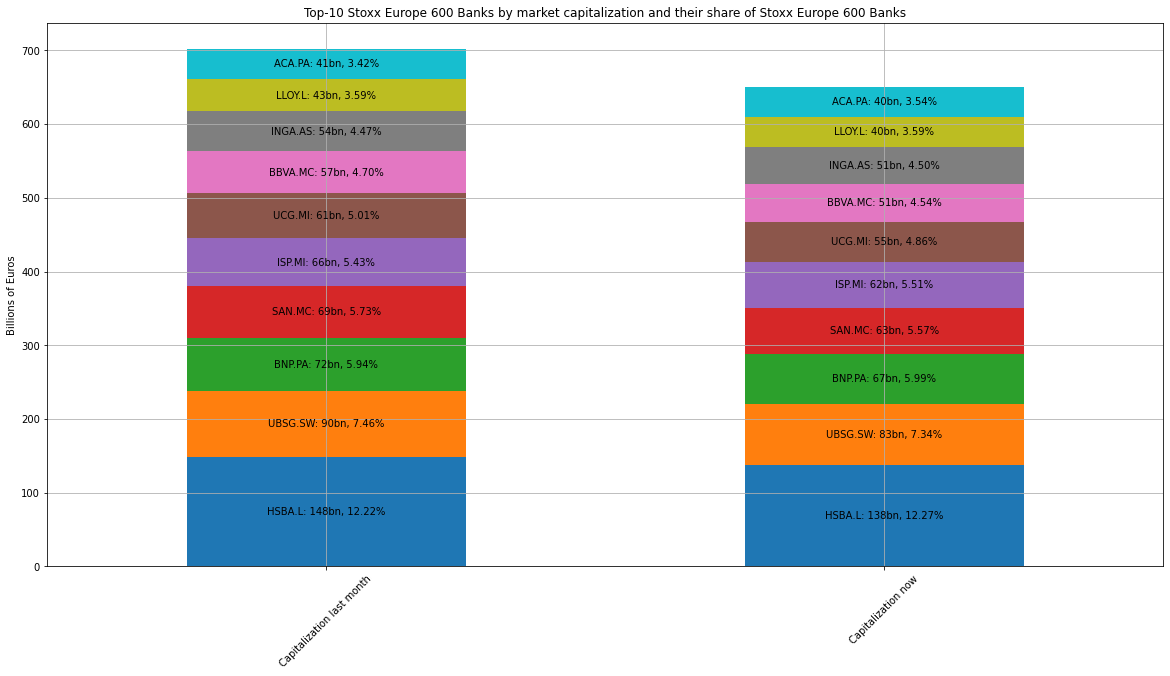

In [13]:
ax = top10_now.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_BANKS,
                          stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [c.get_label() + f': {a:,.0f}bn, {top10_today_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

In [14]:
print(f'The capitalization Stoxx Europe 600 banks on {stoxx600_banks_metrics.capitalization.index[-1]:%Y-%m-%d} is '
      f'€{stoxx600_banks_metrics.capitalization.iloc[-1,0]/1e9:.3f}bn')

The capitalization Stoxx Europe 600 banks on 2024-08-02 is €1126.016bn


## Total annual and daily value of Stoxx Europe 600 Banks stocks traded 
For Stoxx Europe 600 banks I depict average daily trading values over each month. In the first graph I show average daily volumes per month, in the second I show average daily volues per month scaled to annual ammounts.

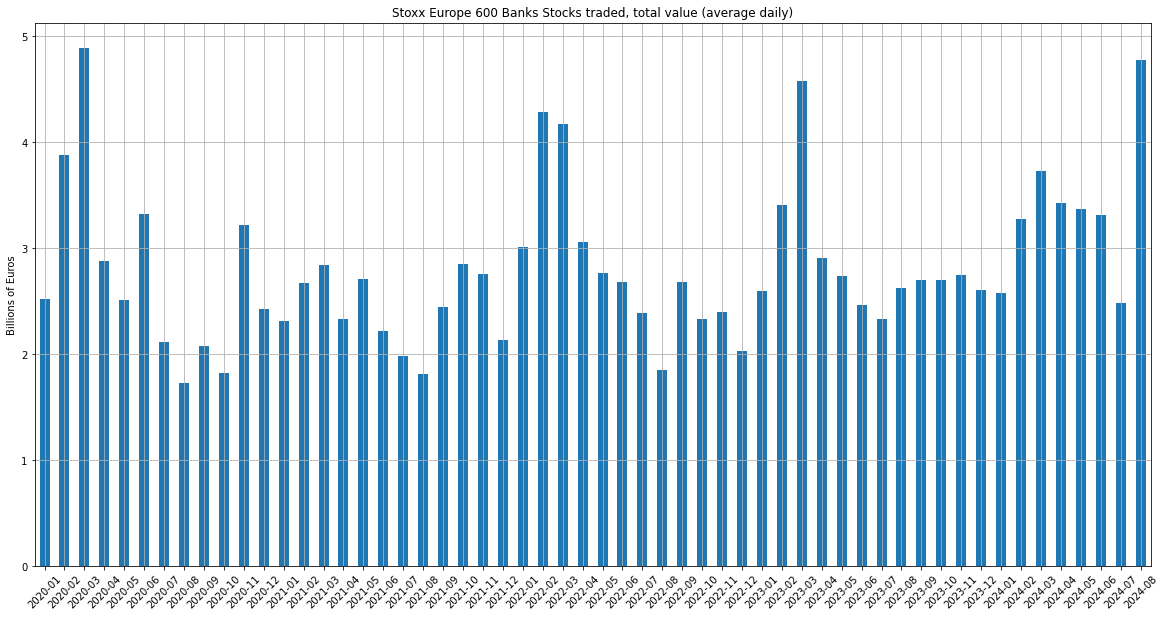

In [15]:
ax = banks_daily_trading_value.plot.bar(figsize=(20,10), grid=True, ylabel=LEFT_Y_AXIS_LABEL,
                                        title=TRAD_VOL_BANKS_GRAPH_TITLE_DAILY, color='#1f77b4',
                                        xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, banks_daily_trading_value.index)))

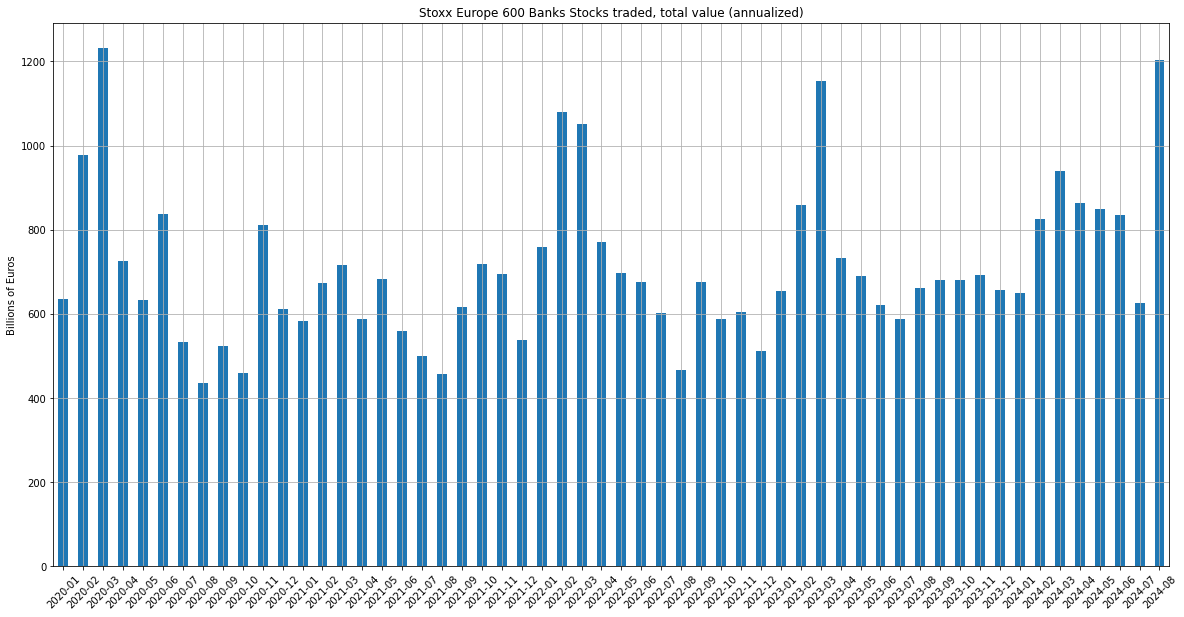

In [16]:
ax = banks_annual_trading_value.plot.bar(figsize=(20,10), grid=True, ylabel=LEFT_Y_AXIS_LABEL,
                                         title=TRAD_VOL_BANKS_GRAPH_TITLE, color='#1f77b4',
                                         xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, banks_annual_trading_value.index)))

## Stocks traded, annual and daily turnover ratios of Stoxx Europe 600 Banks shares to their capitalization
In this section of the notebook I look at the turnover ratio of Stoxx Europe 600 Banks shares traded divided by their market capitalization. The value is annualized by multiplying the monthly average by 12.

If you divide the number for a given year by 252 (the approximate number of trading days), you obtain the percentage of shares that are traded in one day. This ranges between 0.2% and 1%. And such a small fraction of traded shares determine the capitalization of the whole firm.

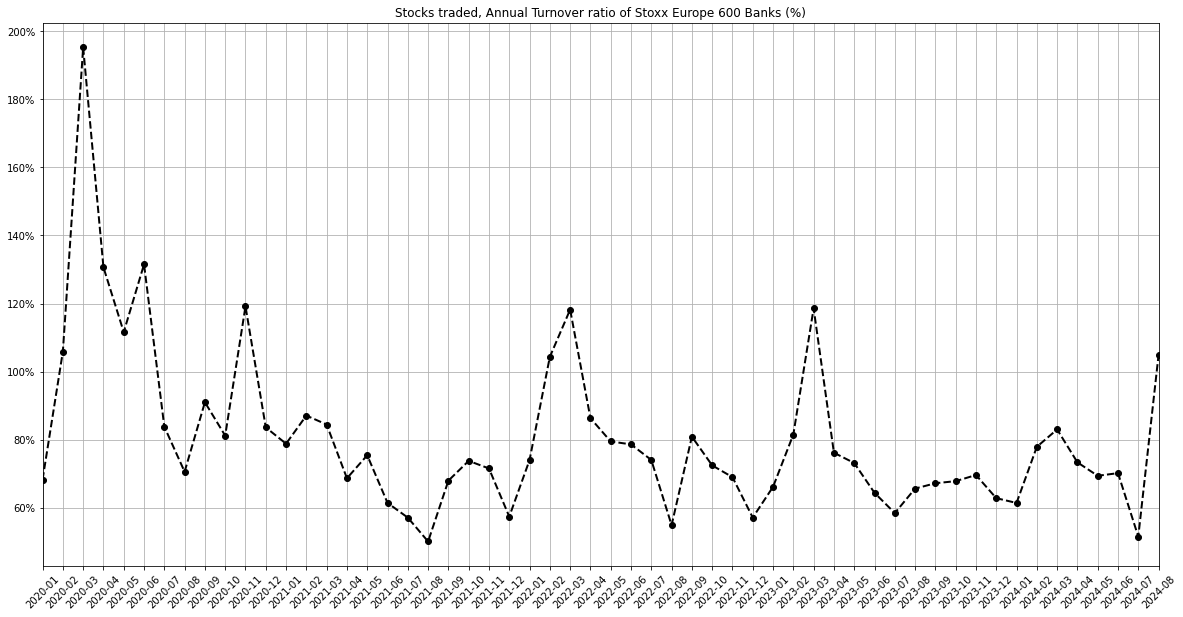

In [17]:
ax = banks_annual_turnover.dropna().plot(figsize=(20,10), grid=True, title=TUROVER_RATIO_BANKS_GRAPH_TITLE,
                                         color='k', marker='o', linestyle='--', linewidth=2,
                                         xticks=banks_annual_turnover.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, banks_annual_turnover.index)))

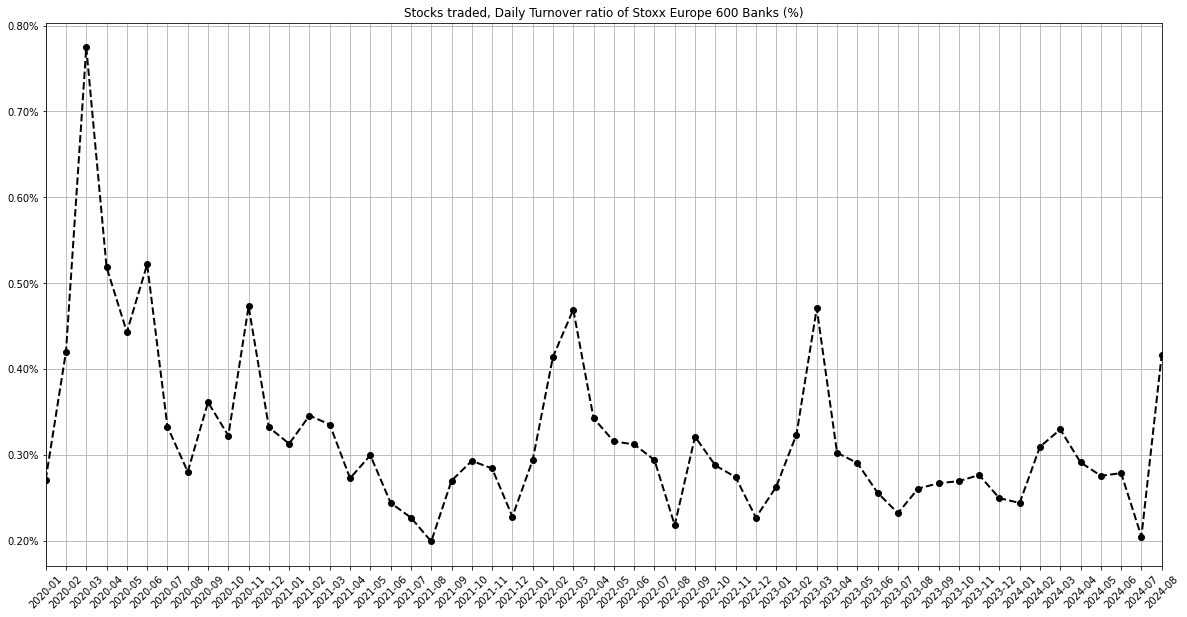

In [18]:
ax = banks_daily_turnover.plot(figsize=(20,10), grid=True,
                               title=TUROVER_RATIO_BANKS_DAILY_GRAPH_TITLE, color='k', marker='o', linestyle='--',
                               linewidth=2, xticks=banks_daily_turnover.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, banks_daily_turnover.index)))

## Forward annual dividend yield of Stoxx Europe 600 Banks

In [19]:
print(f'Stoxx Europe 600 banks forward dividend yield on {stoxx600_banks_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{stoxx600_banks_metrics.forward_dividend_yield:.5%}')

Stoxx Europe 600 banks forward dividend yield on 2024-08-02 is 6.34358%


## Forward Price to Earnings ratio of Stoxx Europe 600 Banks

In [20]:
print(f'Stoxx Europe 600 banks forward P/E on {stoxx600_banks_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{stoxx600_banks_metrics.forward_PE:.2f}')

Stoxx Europe 600 banks forward P/E on 2024-08-02 is 8.44


## Price to Book, Return on Equity, and Cost of Capital of Stoxx Europe 600 Banks
One of the most frequently used tools for analyzing banks is their P/B and ROE ratios. Being traditional businesses for which book value is a meaningful metric, the following equation holds for banks:
$$\frac{P}{B}=\frac{ROE}{\text{Cost-of-equity}}$$
where:
* `P` is the market price of a bank's equity
* `B` is the book value of the bank's equity
* `ROE` is its return on equity

Therefore a popular way to compare banks is to plot their P/B ratios against their ROEs. Banks whose ROE exceeds their cost of equity tend to have their price to book > 1. If the cost of equity was the same for all banks, the points on this graph would form a line. Given that the cost of equity differes slightly among financial institutions, this is not the case but is pretty close for banks that are part of Stoxx Europe 600 banks, which implies they have an alike cost of equity. Their approximate cost of equity can be derived from the above equation.

In the remainder of this notebook I will plot this for Stoxx Europe 600 Banks and derive their approximate cost of equity. I use P/B values based on the book value as reported in the most recent quarter (mrq) and ROE based on the trailing twelve months (ttm). I will also construct a regression line to determine the sensitivity of P/B to ROE changes and derive the banks' cost of equity.

In [21]:
# subset = stoxx600_banks[:]
# subset.remove('RBI.VI')
# subset.remove('BPE.MI')
# subset.remove('SYDB.CO')
# subset.remove('UBSG.SW')
roe_pb = stoxx600_banks_metrics.get_roe_and_pb(stoxx600_banks).dropna()
# Get rid of outliers
roe_pb = roe_pb.loc[~((roe_pb.ROE > .3) | (roe_pb['P/B'] > 5))]
slope, intercept = scipy.stats.linregress(roe_pb.iloc[:,0].to_list(), roe_pb.iloc[:,1].to_list())[0:2]

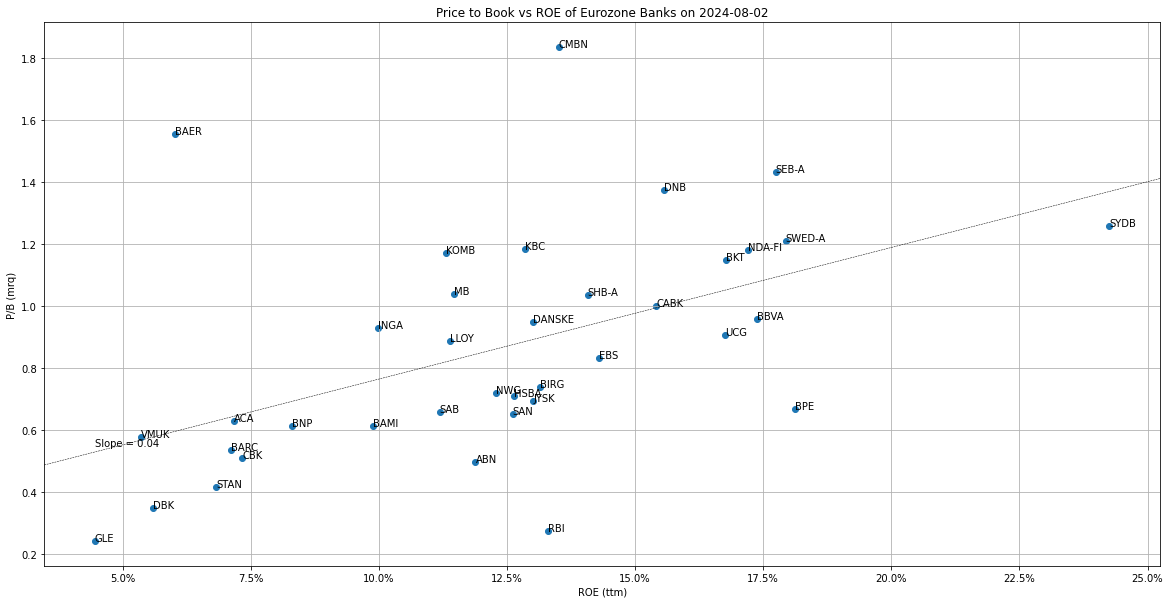

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
sc = ax.scatter(x=roe_pb.iloc[:,0], y=roe_pb.iloc[:,1])

x_min = roe_pb.iloc[:,0].min()
ax.axline((x_min, intercept + slope * x_min), slope=slope, linestyle='--', color='k', linewidth=.5)
plt.text(x_min, intercept + slope * x_min + .02, f'Slope = {slope/100:.2f}')

# Add labels to designate each bank
for ticker, (roe, pb) in roe_pb.iterrows():
    plt.text(roe, pb, ticker.split('.')[0])
    
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlabel(roe_pb.columns[0] + TTM_SUFFIX)
ax.set_ylabel(roe_pb.columns[1] + MRQ_SUFFIX)
ax.set_title(f'Price to Book vs ROE of Eurozone Banks on {stoxx600_banks_metrics.capitalization.index[-1]:%Y-%m-%d}')
ax.grid(True)

In [23]:
print(f'The sensitivity of P/B to ROE for European banks: {slope/100:.2f}\n'
      f"This means that for every percentage point improvement in ROE, the bank's P/B increases by {slope/100:.2f}")

The sensitivity of P/B to ROE for European banks: 0.04
This means that for every percentage point improvement in ROE, the bank's P/B increases by 0.04


In [24]:
print(f'From the above equation it also means that an approximate cost of equity for these banks is: {1./slope:.2%}')
print(roe_pb.index.to_list())

From the above equation it also means that an approximate cost of equity for these banks is: 23.56%
['INGA.AS', 'ABN.AS', 'DBK.DE', 'CBK.DE', 'BNP.PA', 'ACA.PA', 'GLE.PA', 'KBC.BR', 'BIRG.IR', 'BBVA.MC', 'BKT.MC', 'CABK.MC', 'SAB.MC', 'SAN.MC', 'EBS.VI', 'RBI.VI', 'NDA-FI.HE', 'UCG.MI', 'MB.MI', 'BAMI.MI', 'BPE.MI', 'HSBA.L', 'BARC.L', 'LLOY.L', 'NWG.L', 'VMUK.L', 'STAN.L', 'BAER.SW', 'CMBN.SW', 'SEB-A.ST', 'SWED-A.ST', 'SHB-A.ST', 'DANSKE.CO', 'SYDB.CO', 'JYSK.CO', 'DNB.OL', 'KOMB.PR']
